## Bidirectional Neural Representation:

This illustrates the bidirectional representation and learning capability
of a single hidden-layer network.
The network learns the bidirectional representation over binary and bipolar 
permutation functions.

Bipolar permutation function $f: \{-1,1\}^n \rightarrow \{-1, 1\}^n$. Binary permutation function $f : \{0,1\}^n \rightarrow \{0, 1\}^n$

This code applies to two cases of 3-bit and 4-bit permutation functions.

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

2024-09-04 00:02:48.878561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 00:02:50.059811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 3-bit and 4-bit bipolar permutation
def get_data(data_type = "3_bits"):
    """
    Generate the training dataset for a pre-defined 
    3-bit or 4-bit permutation function
    """
    
    if data_type == "3_bits":
        x = np.array([
            [1,1,1], [1,1,-1], [1,-1,1], [1,-1,-1],
            [-1,1,1], [-1,1,-1], [-1,-1,1], [-1,-1,-1]])
        y = x[[6,4,2,0,7,5,3,1]]      
    elif data_type == "4_bits":
        x = np.array([
            [-1,-1,-1,-1],[-1,-1,-1,1],[-1,-1,1,-1],[-1,-1,1,1],
            [-1,1,-1,-1],[-1,1,-1,1],[-1,1,1,-1],[-1,1,1,1],
            [1,-1,-1,-1],[1,-1,-1,1],[1,-1,1,-1],[1,-1,1,1],
            [1,1,-1,-1],[1,1,-1,1],[1,1,1,-1],[1,1,1,1]])
        y = x[[12, 14, 15, 13, 9, 5, 8, 4, 11, 7, 10, 6, 2, 0, 1, 3]]
    else:
        raise ValueError("Wrong input!!! Data type should be 3_bits or 4_bits")
    return x, y

In [3]:
data_type = "4_bits"  # "4_bit"
num_hidden_neurons = 5
mode = 'bipolar'  # "bipolar"
num_epochs = 5000

In [4]:
X, Y = get_data(data_type)
if mode == 'binary':
  X = 0.5 * (X+1)
  Y = 0.5 * (Y+1)

###### Network Architecture: Input layer <--> Hidden Layer <--> Output Layer

In [5]:
## Define the Placeholders !!!
xf = tf.compat.v1.placeholder(tf.float32, [None, X.shape[1]], name = 'input_forward')
yf = tf.compat.v1.placeholder(tf.float32, [None, Y.shape[1]], name = 'target_forward')

xb = tf.compat.v1.placeholder(tf.float32, [None, X.shape[1]], name = 'input_backward')
yb = tf.compat.v1.placeholder(tf.float32, [None, Y.shape[1]], name = 'target_backward')

In [6]:
## Initialize weight
wgts = {}
wgts['U'] = tf.Variable(
    tf.compat.v1.random_normal(
        [X.shape[1], num_hidden_neurons], 
        stddev = 1.0)
    )
wgts['W'] = tf.Variable(
    tf.compat.v1.random_normal(
        [Y.shape[1], num_hidden_neurons], 
        stddev = 1.0)
    )

In [7]:
# Forward Pass
ah_f = tf.nn.sigmoid(tf.matmul(xf, wgts['U']))
oy_f = tf.matmul(ah_f, tf.transpose(wgts['W']))
ay_f = oy_f

# Backward Pass
ah_b = tf.nn.sigmoid(tf.matmul(yb, wgts['W']))
ox_b = tf.matmul(ah_b, tf.transpose(wgts['U']))
ax_b = ox_b

In [8]:
# Define the loss function and optimizer
with tf.device('/device:CPU:0'):
  if mode == "binary":
    loss_f = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = yf, logits =  ay_f))
    loss_b = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = xb, logits =  ax_b))
  
  elif mode == "bipolar":
    yf_ = 0.5 * (yf + 1.0)
    xb_ = 0.5 * (xb + 1.0)
    loss_f = tf.reduce_mean(
        tf.maximum(2*ay_f, 0)-(2*ay_f*yf_) + tf.math.log(1 + tf.exp(-tf.abs(2*ay_f)))
        )
    loss_b = tf.reduce_mean(
        tf.maximum(2*ax_b, 0)-(2*ax_b*xb_) + tf.math.log(1 + tf.exp(-tf.abs(2*ax_b)))
        )
  loss = loss_f + loss_b
  optimizer = tf.compat.v1.train.GradientDescentOptimizer(
        learning_rate = 0.5).minimize(loss)

In [9]:
val_f = np.array([])
val_b = np.array([])

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

2024-09-04 00:02:53.075938: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-04 00:02:53.089158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


#### Training

In [10]:
# Train the bidirectional network
val_f = np.array([])
val_b = np.array([])

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

for idx in range(num_epochs + 1):

  # Evaluate the model
  if idx % 50 == 0:
    ef, eb = sess.run([loss_f, loss_b],
                        feed_dict= {xf: X, yf: Y, xb: X, yb: Y})
    val_f = np.append(val_f, ef)
    val_b = np.append(val_b, eb)

  # Update the weights
  sess.run(optimizer, feed_dict= {xf: X, yf: Y, xb: X, yb: Y})

#### Evaluation

In [11]:
# Evaluate the model
pred_y, pred_x= sess.run([ay_f, ax_b],
                         feed_dict= {xf: X, yf: Y, xb: X, yb: Y})

In [12]:
pred_y = (pred_y >= 0).astype(float)
pred_x = (pred_x >= 0).astype(float)
if mode == "bipolar":
  pred_y = (2*pred_y) - 1
  pred_x = (2*pred_x) - 1

In [13]:
# Forward Pass: Compute the approximation error
X - pred_x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [14]:
# Backward Pass: Compute the approximation error
Y - pred_y

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

#### Synaptic weights (Post-training)

In [15]:
sess.run(wgts['W']).T

array([[-8.297952  ,  1.5511893 , -4.689498  ,  4.5780907 ],
       [ 5.752839  ,  3.8872056 ,  1.5554489 , -6.140025  ],
       [ 5.734231  ,  5.4592466 ,  0.38746276,  7.3866625 ],
       [-4.2735777 , -3.246866  ,  7.5305367 , -3.1191318 ],
       [ 1.5879892 , -7.13687   , -5.0675545 , -2.9086556 ]],
      dtype=float32)

In [16]:
sess.run(wgts['U'])

array([[ 2.9000123, -6.468402 , -5.556801 ,  7.4288125,  2.0399187],
       [ 5.312729 , -5.0637074, -3.8381968, -3.5059853,  6.6936946],
       [ 4.4820023,  7.2872295, -6.0561175, -2.857265 , -3.053746 ],
       [ 6.5679717, -0.3732676, -1.5945705,  4.1060276, -8.393822 ]],
      dtype=float32)

In [ ]:
### Plot the directional loss fucntions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


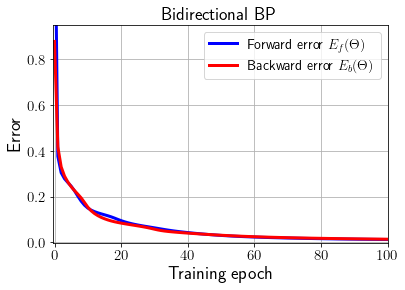

In [19]:
plt.plot(np.arange(0,101), val_f,
         lw =3, color ='blue', label= 'Forward error  ' r'$E_{f}(\Theta)$')
plt.plot(np.arange(0,101), val_b,
         lw =3, color ='red', label = 'Backward error  ' r'$E_{b}(\Theta)$')
plt.grid()


plt.legend(fontsize = 14, loc = 'upper right')
plt.title(r"Bidirectional BP", fontsize = 18)
plt.xlabel(r'Training epoch', fontsize = 18)
plt.ylabel("Error", fontsize = 18)


plt.xlim(-0.5, 100)
plt.ylim(-0.001, 0.95)
plt.xticks([0,20,40,60,80,100], fontsize = 15)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8], fontsize = 15)
plt.savefig("3_bits_Forward_BP.eps",
            format='eps', bbox_inches="tight")
plt.show()